Import classes

In [1]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
from crossbar import crossbar, ticket
from Full_model import Integrated_Model

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np

name: X_test
shape: (640, 35, 2649)
-----------------------
name: X_train
shape: (640, 35, 2564)
-----------------------
name: clip_sizes_test
shape: (2, 102)
-----------------------
name: clip_sizes_train
shape: (2, 101)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2649)
-----------------------
name: sel_win_nums_train
shape: (1, 2564)
-----------------------
name: soz_ch_ids
shape: (7, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2649)
-----------------------
name: y_train
shape: (1, 2564)
-----------------------
print sample EGG signal from one node:


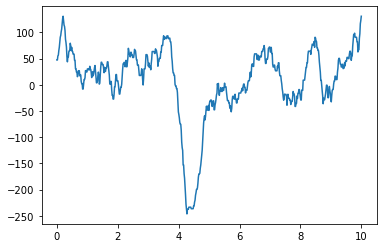

In [2]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_273.mat' #264 253 620 273
variables = load_patient_data(filepath, verbose = True)

In [3]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))

--------data manager successfully initialized--------


In [4]:
#reduce redundant nodes
print(dm)
dm.apply_dvariance_filter(28)
dm.mean_pooling_1d(size = 24, stride = 20, padding = 0)
print(dm)

X_train: shape of(2562, 35, 640)
X_test: shape of(2649, 35, 640)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(35, 35)
A_test: shape of(35, 35)
P_avg_train: shape of(35, 35)
P_avg_test: shape of(35, 35)
--------data successfully filtered (dvariance)--------
X_train: shape of(2562, 28, 31)
X_test: shape of(2649, 28, 31)
Y_train: shape of(2562, 1)
Y_test: shape of(2649, 1)
A_train: shape of(28, 28)
A_test: shape of(28, 28)
P_avg_train: shape of(28, 28)
P_avg_test: shape of(28, 28)


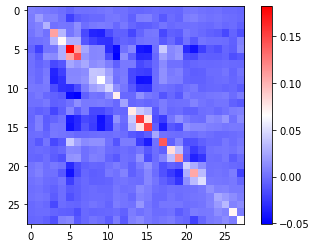

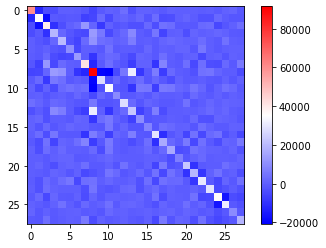

In [5]:
show_heat_map(dm.P_avg_train)
show_heat_map(dm.conv_avg_train)

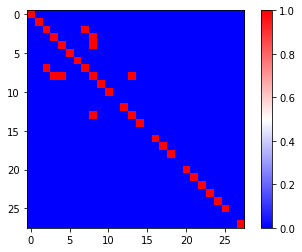

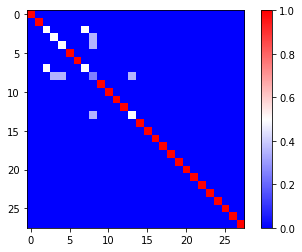

In [6]:
# adjacency generated by convariance
A2 = (dm.conv_avg_train > 10000)# + (dm.conv_avg_train < -8000) 
show_heat_map(A2)
show_heat_map(create_DAD(A2))

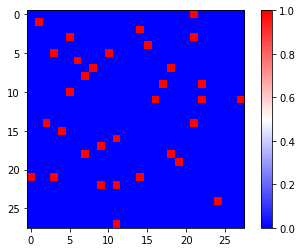

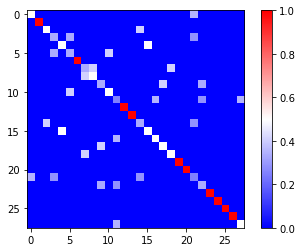

In [7]:
#randomly generated A
b = np.random.randint(-2000,2000,size=dm.conv_avg_train.shape)
A3 = (b + b.T)/2 > 1500
show_heat_map(A3)
show_heat_map(create_DAD(A3))

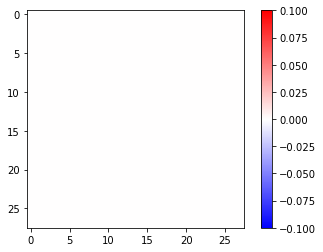

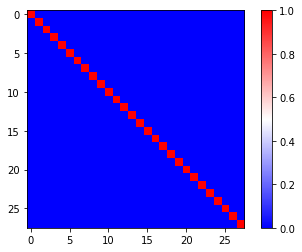

In [8]:
n = 1000.5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
#print(create_DAD(dm.A_train))
Araw =  A3#dm.A_train

#### Crossbar GCN

In [9]:
device_params_A = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 56,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.05,
                 "p_stuck_off": 0.05,
                 "method": "viability",
                 "viability": 0.05,
}
device_params_W = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 64,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.05,
                 "p_stuck_off": 0.05,
                 "method": "viability",
                 "viability": 0.05,
}
GCNparameters = {
    'body': dm.X_train.shape[2],
    'M': dm.X_train.shape[0],
    'batch_size': 256,
    'n_layers': 2,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3,
    'cb_A': crossbar(device_params_A),
    'cb_Ws': [crossbar(device_params_W), crossbar(device_params_W)]
}
checkpoint = {'parameters': GCNparameters}
#print(GCNparameters['cb_Ws'])

In [10]:
from GCN import *
from tqdm import tqdm

# takes in numpy arrays
def train_GCN_wCB(A, X_train, X_test, checkpoint, device_name='cpu', load=False):
    # preprocess inputs
    A = torch.from_numpy(A).float()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    if device_name == 'cuda':
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        print("device set to cuda") if device == torch.device('cuda') else print("cuda is not available")
    elif device_name == 'cpu':
        device = torch.device('cpu')
        print("device set to cpu")
    else:
        device = torch.device('cpu')
        print("unknown device")
    parameters = checkpoint['parameters']
    cumepoch = 0
    A = A.to(device)
    input_features = X_train.to(device)
    valid_features = X_test.to(device)

    # initialize model
    model = Net_wCB(parameters['body'], parameters['n_layers'],A, parameters['cb_A'], parameters['cb_Ws'], F.relu).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'],weight_decay=parameters['weight_decay']) #torch.optim.SGD(model.parameters(), lr=parameters['learning_rate'], momentum=0.5)
    criterion = sim_loss()

    # load past checkpoint if any
    if load:
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        cumepoch = checkpoint['cumepoch']

    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']

    model.train()
    for epoch in range(1, n_epochs + 1):

        permutation = torch.randperm(input_features.shape[0])
        permutation_v = torch.randperm(valid_features.shape[0])

        for i in tqdm(range(0, input_features.shape[0], batch_size)):
            model.train()
            optimizer.zero_grad()

            indices = permutation[i:i + batch_size] if i + batch_size < input_features.shape[0] else permutation[i:]
            indices_v = permutation_v[i:i + batch_size] if i + batch_size < valid_features.shape[0] else permutation_v[i:]
            batch_x = input_features[indices, :, :]
            batch_v = valid_features[indices_v, :, :]

            sim_matrix = model(batch_x).to(device)
            train_loss = criterion(sim_matrix, A)
            train_loss.backward()
            optimizer.step()
            model.remap()

            model.eval()
            sim_matrix_valid = model(batch_v).to(device)
            valid_loss = criterion(sim_matrix_valid, A)

            print("Epoch:", epoch + cumepoch, "  Batch:", int((i / batch_size) + 1), "of size", batch_size,
                  "  Train loss:", float(train_loss), "  Valid loss:", float(valid_loss), end="\r")
        print()

    checkpoint = {
        'parameters': parameters,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'cumepoch': n_epochs + cumepoch
    }

    return model, checkpoint

In [11]:
GCNcb, GCNcbCheckpoint = train_GCN_wCB(create_DAD(Araw), dm.X_train, dm.X_test, checkpoint, device_name='cpu', load=False)

device set to cpu


  0%|          | 0/11 [00:00<?, ?it/s]

remap successfully


  9%|▉         | 1/11 [05:42<57:01, 342.13s/it]

remap successfully1 of size 256   Train loss: 187.10630798339844   Valid loss: 185.48052978515625


 18%|█▊        | 2/11 [11:26<51:24, 342.76s/it]

remap successfully2 of size 256   Train loss: 185.57937622070312   Valid loss: 183.89572143554688


 27%|██▋       | 3/11 [17:09<45:43, 342.99s/it]

remap successfully3 of size 256   Train loss: 183.94534301757812   Valid loss: 182.2668914794922


 36%|███▋      | 4/11 [22:51<39:57, 342.45s/it]

remap successfully4 of size 256   Train loss: 182.3967742919922   Valid loss: 180.78379821777344


 45%|████▌     | 5/11 [28:35<34:17, 342.98s/it]

remap successfully5 of size 256   Train loss: 180.71311950683594   Valid loss: 179.27996826171875


 55%|█████▍    | 6/11 [34:20<28:38, 343.80s/it]

remap successfully6 of size 256   Train loss: 179.40658569335938   Valid loss: 177.87139892578125


 64%|██████▎   | 7/11 [40:02<22:52, 343.17s/it]

remap successfully7 of size 256   Train loss: 177.74606323242188   Valid loss: 176.46180725097656


 73%|███████▎  | 8/11 [45:50<17:13, 344.44s/it]

remap successfully8 of size 256   Train loss: 176.439208984375   Valid loss: 175.00526428222656


 82%|████████▏ | 9/11 [51:36<11:30, 345.14s/it]

remap successfully9 of size 256   Train loss: 175.04266357421875   Valid loss: 173.66732788085938


 91%|█████████ | 10/11 [57:24<05:45, 345.76s/it]

remap successfully10 of size 256   Train loss: 173.7068634033203   Valid loss: 172.2856903076172


100%|██████████| 11/11 [58:25<00:00, 318.71s/it]

Epoch: 1   Batch: 11 of size 256   Train loss: 172.4943084716797   Valid loss: 171.58319091796875


In [12]:
GCNcb.eval()
test_pred = GCNcb(torch.from_numpy(dm.X_train[:128, :,:]).float().to('cpu')).cpu().detach().numpy()

sample 0   label, 0.0


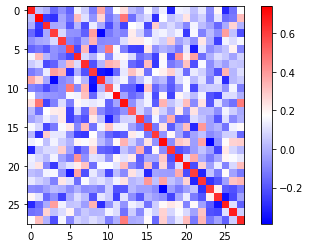

sample 1   label, 0.0


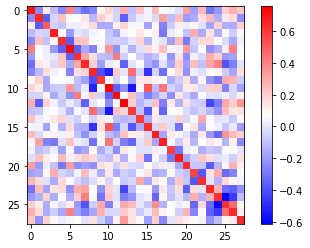

sample 2   label, 0.0


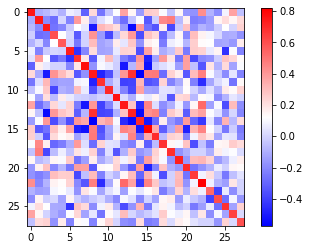

sample 3   label, 0.0


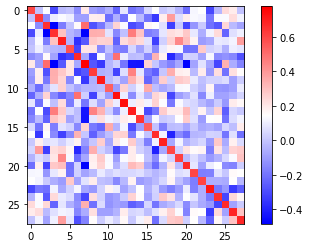

sample 4   label, 0.0


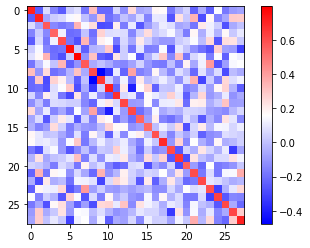

sample 5   label, 0.0


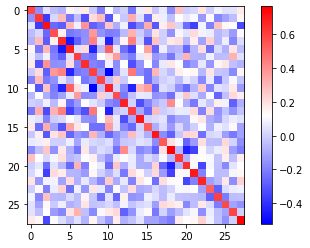

sample 6   label, 0.0


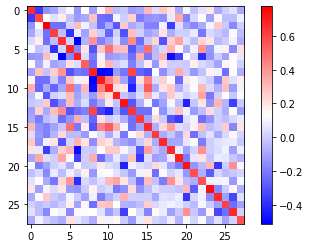

sample 7   label, 0.0


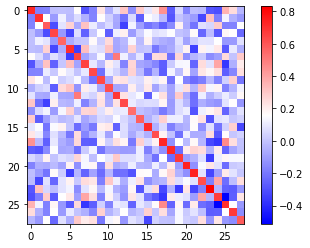

sample 8   label, 0.0


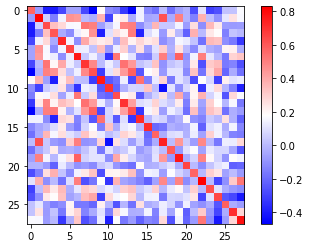

sample 9   label, 0.0


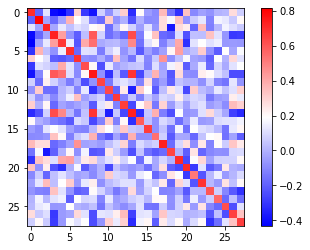

In [13]:
for i in range(10):
    print("sample", i, "  label,", dm.Y_train[i,0])
    show_heat_map(test_pred[i,:,:])

MLP

In [14]:
#Get simularity matrix from GCN
sim_all = {}
GCNcb.eval()
sim_all["GCN_train"] = GCNcb(torch.from_numpy(dm.X_train).float().to('cpu')).cpu().detach().numpy()
sim_all["GCN_test"] = GCNcb(torch.from_numpy(dm.X_test).float().to('cpu')).cpu().detach().numpy()

Average Ictal and Non-Ictal Simularity Matrix for GCN
Average ictal


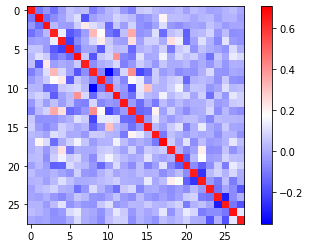

Average Non-Ictal


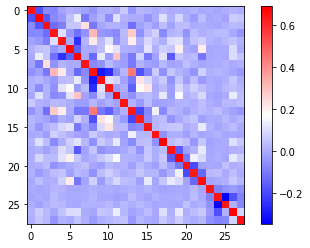

In [15]:
print("Average Ictal and Non-Ictal Simularity Matrix for GCN")
visualize_avg_sim_matrix(dm, sim_all["GCN_train"], sim_all["GCN_test"])

In [28]:
#Without crossbar

In [29]:
MLPparametersGCN = {
    'n_layers':2,
    'layer_size_factor':[1,50], 
    'dropout':[0.3, 0.15],
    'batch_size': 128,
    'num_epochs': 900,
    'learning_rate': 6e-4,
    'weight_decay': 5e-3,
    'betas': (0.9, 0.999), 
    'eps': 1e-08
}
MLPmodelGCN, _,_, MLPcheckpointGCN = MLP.train_MLP(dm, sim_all["GCN_train"], sim_all["GCN_test"], MLPparametersGCN, acc_fn=MLP.auc2, autostop_decay = 0.995, print_summary = True)

MLP(
  (layers): ModuleList(
    (0): Dropout(p=0.3, inplace=False)
    (1): Linear(in_features=406, out_features=8, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=8, out_features=1, bias=True)
    (5): Sigmoid()
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1                  [-1, 406]               0
            Linear-2                    [-1, 8]           3,256
              ReLU-3                    [-1, 8]               0
           Dropout-4                    [-1, 8]               0
            Linear-5                    [-1, 1]               9
           Sigmoid-6                    [-1, 1]               0
Total params: 3,265
Trainable params: 3,265
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Esti

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


0.695 ----------saved-----------
Epoch: 4   Train loss: 0.3819   Train accuracy: nan   Val loss: 0.3866   Val accuracy: 0.718    weighted Val loss: 0.6549
0.718 ----------saved-----------
Epoch: 5   Train loss: 0.3418   Train accuracy: nan   Val loss: 0.351   Val accuracy: 0.744    weighted Val loss: 0.6534
0.744 ----------saved-----------
Epoch: 6   Train loss: 0.331   Train accuracy: 0.723   Val loss: 0.3284   Val accuracy: 0.775    weighted Val loss: 0.6518
0.775 ----------saved-----------
Epoch: 7   Train loss: 0.2804   Train accuracy: nan   Val loss: 0.3167   Val accuracy: 0.788    weighted Val loss: 0.6501
0.788 ----------saved-----------
Epoch: 8   Train loss: 0.2557   Train accuracy: nan   Val loss: 0.3058   Val accuracy: 0.803    weighted Val loss: 0.6484
0.803 ----------saved-----------
Epoch: 9   Train loss: 0.2472   Train accuracy: nan   Val loss: 0.2971   Val accuracy: 0.814    weighted Val loss: 0.6466
0.814 ----------saved-----------
Epoch: 10   Train loss: 0.2354   Trai

C:\Users\caixu\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "


Epoch: 103   Train loss: 0.1856   Train accuracy: nan   Val loss: 0.1856   Val accuracy: 0.907    weighted Val loss: 0.481
0.907 ----------saved-----------
Epoch: 104   Train loss: 0.1064   Train accuracy: nan   Val loss: 0.1925   Val accuracy: 0.907    weighted Val loss: 0.4796
Epoch: 105   Train loss: 0.0931   Train accuracy: nan   Val loss: 0.1885   Val accuracy: 0.908    weighted Val loss: 0.4781
0.908 ----------saved-----------
Epoch: 106   Train loss: 0.1179   Train accuracy: 0.975   Val loss: 0.1873   Val accuracy: 0.907    weighted Val loss: 0.4767
Epoch: 107   Train loss: 0.0946   Train accuracy: nan   Val loss: 0.1906   Val accuracy: 0.905    weighted Val loss: 0.4752
Epoch: 108   Train loss: 0.0958   Train accuracy: nan   Val loss: 0.1883   Val accuracy: 0.905    weighted Val loss: 0.4738
Epoch: 109   Train loss: 0.0905   Train accuracy: nan   Val loss: 0.1889   Val accuracy: 0.906    weighted Val loss: 0.4724
Epoch: 110   Train loss: 0.0897   Train accuracy: nan   Val loss:

device set to cuda
threshold: 0.05  validation loss: 0.1762 F1 accuracy 0.533 Precision accuracy 0.384 Recall accuracy 0.871 AUC accuracy: 0.922
device set to cuda
threshold: 0.1  validation loss: 0.1762 F1 accuracy 0.613 Precision accuracy 0.503 Recall accuracy 0.783 AUC accuracy: 0.922
device set to cuda
threshold: 0.15  validation loss: 0.1762 F1 accuracy 0.66 Precision accuracy 0.587 Recall accuracy 0.753 AUC accuracy: 0.922
device set to cuda
threshold: 0.2  validation loss: 0.1762 F1 accuracy 0.671 Precision accuracy 0.652 Recall accuracy 0.692 AUC accuracy: 0.922
device set to cuda
threshold: 0.25  validation loss: 0.1762 F1 accuracy 0.689 Precision accuracy 0.728 Recall accuracy 0.654 AUC accuracy: 0.922
device set to cuda
threshold: 0.3  validation loss: 0.1762 F1 accuracy 0.679 Precision accuracy 0.761 Recall accuracy 0.614 AUC accuracy: 0.922
device set to cuda
threshold: 0.35  validation loss: 0.1762 F1 accuracy 0.693 Precision accuracy 0.819 Recall accuracy 0.6 AUC accurac

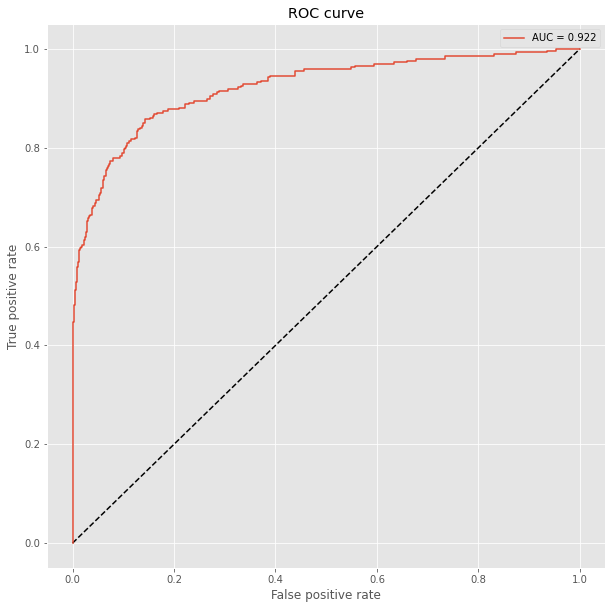

In [30]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda', threshold = t)
MLP.eval_plot_MLP(MLPmodelGCN, sim_all["GCN_test"], dm, device_name = 'cuda')

In [31]:
#With crossbar (ex-situ)

In [35]:
device_params_MLPW1 = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 512,
                 "n": 16,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.5,
                 "p_stuck_off": 0.05,
                 "method": "viability",
                 "viability": 0.05,
}

device_params_MLPW2 = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 16,
                 "n": 16,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.05,
                 "p_stuck_off": 0.05,
                 "method": "viability",
                 "viability": 0.05,
}


In [36]:
MLPGCNCBmodel = MLP.MLPtoMLPwCB(MLPmodelGCN.to('cpu'), [device_params_MLPW1,device_params_MLPW2])

0 layers.1.weight torch.Size([8, 406])
1 layers.1.bias torch.Size([8])
2 layers.4.weight torch.Size([1, 8])
3 layers.4.bias torch.Size([1])
--- weight initialized successfually ---
--- weight initialized successfually ---


In [ ]:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPGCNCBmodel, sim_all["GCN_test"], dm, device_name = 'cpu', threshold = t)
MLP.eval_plot_MLP(MLPGCNCBmodel, sim_all["GCN_test"], dm, device_name = 'cpu')

  0%|          | 0/2649 [00:00<?, ?it/s]

device set to cpu


  0%|          | 2/2649 [00:00<02:21, 18.74it/s]

threshold: 0.05  validation loss: 1.1241 F1 accuracy 0.2 Precision accuracy 0.111 Recall accuracy 1.0 AUC accuracy: 0.649
device set to cpu


  0%|          | 2/2649 [00:00<03:07, 14.12it/s]

threshold: 0.1  validation loss: 1.1241 F1 accuracy 0.201 Precision accuracy 0.112 Recall accuracy 1.0 AUC accuracy: 0.649
device set to cpu


  0%|          | 2/2649 [00:00<02:35, 17.07it/s]

threshold: 0.15  validation loss: 1.1241 F1 accuracy 0.201 Precision accuracy 0.112 Recall accuracy 1.0 AUC accuracy: 0.649
device set to cpu


 28%|██▊       | 748/2649 [00:39<01:39, 19.09it/s]

#### Crossbar GDE

In [120]:
device_params_A = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 56,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}
device_params_W = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 32,
                 "n": 64,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}
GDEparameters = {
    'body': dm.X_train.shape[2],
    'solver': GDEsolvers.explicit_RK,
    'solver_params': {
    "t0": 0,
    "t1": 0.25,
    "N": 5,
    "b_tableau": GDEsolvers.EF
     },
    'hidden_layers': 1,
    'M': dm.X_train.shape[0],
    'batch_size': 128,
    'num_epochs': 1,
    'learning_rate': 1e-3,
    'weight_decay': 5e-3,
    'cb_A': crossbar(device_params_A),
    'cb_Ws': [crossbar(device_params_W)]
}
GEDcheckpoint = {'parameters': GDEparameters}

In [121]:
from GDE import *
from tqdm import tqdm

def train_GDE_wCB(A, X_train, X_test, checkpoint, device_name = 'cpu',load=False):
    # preprocess inputs
    A = torch.from_numpy(A).float()
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    if device_name == 'cuda':
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        print("device set to cuda") if device == torch.device('cuda') else print("cuda is not available")
    elif device_name == 'cpu':
        device = torch.device('cpu')
        print("device set to cpu")
    else:
        device = torch.device('cpu')
        print("unknown device")
    parameters = checkpoint['parameters']
    cumepoch = 0
    A = A.to(device)
    input_features = X_train.to(device)
    valid_features = X_test.to(device)

    # (solver, body_channels, hidden_layers, A, solver_params)
    # initialize model
    model = ODENet_wCB(parameters['solver'], parameters['body'], parameters['hidden_layers'], A,
                   parameters['solver_params'], parameters['cb_A'], parameters['cb_Ws']).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters['learning_rate'],
                                 weight_decay=parameters['weight_decay'])
    criterion = sim_loss()

    # load past checkpoint if any
    if load:
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        cumepoch = checkpoint['cumepoch']

    n_epochs = parameters['num_epochs']
    batch_size = parameters['batch_size']

    model.train()
    for epoch in range(1, n_epochs + 1):

        permutation = torch.randperm(input_features.shape[0])
        permutation_v = torch.randperm(valid_features.shape[0])

        for i in tqdm(range(0, input_features.shape[0], batch_size)):
            model.train()
            optimizer.zero_grad()

            indices = permutation[i:i + batch_size] if i + batch_size < input_features.shape[0] else permutation[i:]
            indices_v = permutation_v[i:i + batch_size] if i + batch_size < valid_features.shape[0] else permutation_v[i:]
            batch_x = input_features[indices, :, :]
            batch_v = valid_features[indices_v, :, :]

            sim_matrix = model(batch_x).to(device)
            train_loss = criterion(sim_matrix, A)
            train_loss.backward()
            optimizer.step()
            model.remap()

            model.eval()
            sim_matrix_valid = model(batch_v).to(device)
            valid_loss = criterion(sim_matrix_valid, A)

            print("Epoch:", epoch + cumepoch, "  Batch:", int((i / batch_size) + 1), "of size", batch_size,
                  "  Train loss:", float(train_loss), "  Valid loss:", float(valid_loss), end="\r")
        print()

    checkpoint = {
        'parameters': parameters,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'cumepoch': n_epochs + cumepoch
    }

    return model, checkpoint

In [ ]:
GDEcb, GDEcbCheckpoint = train_GDE_wCB(create_DAD(Araw), dm.X_train, dm.X_test, GEDcheckpoint, device_name='cpu', load=False)

device set to cpu


  0%|          | 0/21 [00:00<?, ?it/s]

remap successfully


  5%|▍         | 1/21 [15:18<5:06:04, 918.25s/it]

remap successfully1 of size 128   Train loss: 180.92776489257812   Valid loss: 179.40713500976562


 10%|▉         | 2/21 [31:55<4:58:18, 942.03s/it]

remap successfully2 of size 128   Train loss: 179.287353515625   Valid loss: 177.85211181640625


 14%|█▍        | 3/21 [50:07<4:56:02, 986.83s/it]

remap successfully3 of size 128   Train loss: 177.73851013183594   Valid loss: 176.2049560546875


 19%|█▉        | 4/21 [1:05:30<4:34:13, 967.85s/it]

remap successfully4 of size 128   Train loss: 176.1518096923828   Valid loss: 174.74716186523438


 24%|██▍       | 5/21 [1:20:58<4:14:53, 955.84s/it]

remap successfully5 of size 128   Train loss: 174.7337188720703   Valid loss: 173.460205078125


 29%|██▊       | 6/21 [1:36:23<3:56:36, 946.45s/it]

remap successfully6 of size 128   Train loss: 173.16336059570312   Valid loss: 171.93389892578125


 33%|███▎      | 7/21 [1:51:51<3:39:35, 941.09s/it]

remap successfully7 of size 128   Train loss: 171.830810546875   Valid loss: 170.4968719482422


 38%|███▊      | 8/21 [2:07:19<3:23:01, 937.06s/it]

remap successfully8 of size 128   Train loss: 170.36790466308594   Valid loss: 169.30300903320312


 43%|████▎     | 9/21 [2:22:39<3:06:25, 932.09s/it]

remap successfully9 of size 128   Train loss: 168.940673828125   Valid loss: 167.68002319335938


 48%|████▊     | 10/21 [2:37:57<2:50:06, 927.84s/it]

remap successfully10 of size 128   Train loss: 167.5545196533203   Valid loss: 166.17422485351562


 52%|█████▏    | 11/21 [2:53:15<2:34:08, 924.86s/it]

remap successfully11 of size 128   Train loss: 166.4916534423828   Valid loss: 165.0355682373047


 57%|█████▋    | 12/21 [3:08:39<2:18:41, 924.61s/it]

# 

## Archives|

Import classes|

In [2]:
%reload_ext autoreload
%autoreload 2
#Custom Files
from DataManager import dataManager
from DataManagerUtil import *
import GCN as GCN
import GCNutil as GCNutil
import GDE as GDE
import GDEutil as GDEutil
import GDEsolvers as GDEsolvers
import MLP as MLP
import crossbar

#Standard Libraries
# Torch
import torch
import torch.autograd
import torch.nn as nn
import torch.nn.functional as F
#Numpy
import numpy as np
#Memtorch
import memtorch
#pandas
import pandas as pd
#Others
import copy

Load Dataset

name: X_test
shape: (640, 23, 2625)
-----------------------
name: X_train
shape: (640, 23, 2473)
-----------------------
name: clip_sizes_test
shape: (2, 135)
-----------------------
name: clip_sizes_train
shape: (2, 133)
-----------------------
name: conv_sizes
shape: (1, 1)
-----------------------
name: n_pre_szr
shape: (1, 1)
-----------------------
name: sel_win_nums_test
shape: (1, 2625)
-----------------------
name: sel_win_nums_train
shape: (1, 2473)
-----------------------
name: soz_ch_ids
shape: (5, 1)
-----------------------
name: stride_sec
shape: (1, 1)
-----------------------
name: window_size_sec
shape: (1, 1)
-----------------------
name: y_test
shape: (1, 2625)
-----------------------
name: y_train
shape: (1, 2473)
-----------------------
print sample EGG signal from one node:


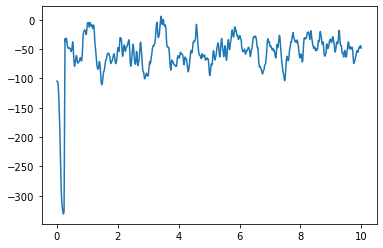

In [3]:
#Loading everything from the dataset
filepath = 'datasets\pat_FR_253.mat' #264 253 620
variables = load_patient_data(filepath, verbose = True)

In [4]:
#OPTIONAL: Shuffle the dataset
indices = np.load("datasets/indices_253.npy")# load shuffled indices
variables, indices = shuffle_train_test(variables, train_ratio = 0.5, indices = indices, print_summary = True)

X_train: (640, 23, 2549)
X_test: (640, 23, 2549)
y_train: (1, 2549) Positive labes: 261.0
y_test: (1, 2549) Positive labes: 260.0


In [5]:
#OPTIONAL: Remove Overlapping Parts
variables = remove_overlap(variables)

Load Models

--------data manager successfully initialized--------


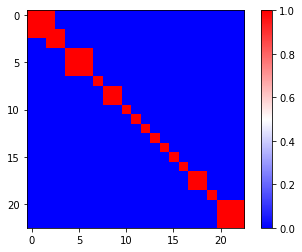

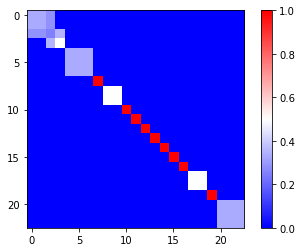

device set to cpu
device set to cpu


In [6]:
dm = dataManager(variables["X_train"],variables["X_test"],variables["y_train"],variables["y_test"],10**(-4))
n = 3.5*10**-3
dm.re_threshold(n)
show_heat_map(dm.A_train)
show_heat_map(create_DAD(dm.A_train))
Araw = dm.A_train
A = create_DAD(Araw)
GCNmodel, GCNoptimizer = GCNutil.load_model(GCNutil.load_ckp("models/GCN253_1.pt"), device_name ='cpu' )
MLPGCNmodel, MLPGCNoptimizer = MLP.load_model(MLP.load_ckp("models/MLPGCN253_2.pt"), A.shape[1], device_name ='cpu' )

In [7]:
sim_all = {}
A = create_DAD(Araw)
X_train = dm.X_train
X_test = dm.X_test
device_name = 'cpu'

#Get simularity matrix from GCN
GCNmodel.eval()
#print(GCNmodel)
#print(A.shape)
#print(X_train.shape)
sim_all["GCN_train"] = GCNmodel(torch.from_numpy(X_train).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()
sim_all["GCN_test"] = GCNmodel(torch.from_numpy(X_test).float().to(device_name), torch.from_numpy(A).float().to(device_name)).cpu().detach().numpy()

In [8]:
#ideal accuracy:
for i in range(5,100, 5):
    t = i/100;
    MLP.eval_mlp(MLPGCNmodel, sim_all["GCN_test"], dm, threshold = t)

device set to cpu
threshold: 0.05  validation loss: 0.1371 F1 accuracy 0.596 Precision accuracy 0.442 Recall accuracy 0.915 AUC accuracy: 0.959
device set to cpu
threshold: 0.1  validation loss: 0.1371 F1 accuracy 0.653 Precision accuracy 0.517 Recall accuracy 0.888 AUC accuracy: 0.959
device set to cpu
threshold: 0.15  validation loss: 0.1371 F1 accuracy 0.702 Precision accuracy 0.591 Recall accuracy 0.865 AUC accuracy: 0.959
device set to cpu
threshold: 0.2  validation loss: 0.1371 F1 accuracy 0.72 Precision accuracy 0.633 Recall accuracy 0.835 AUC accuracy: 0.959
device set to cpu
threshold: 0.25  validation loss: 0.1371 F1 accuracy 0.732 Precision accuracy 0.665 Recall accuracy 0.815 AUC accuracy: 0.959
device set to cpu
threshold: 0.3  validation loss: 0.1371 F1 accuracy 0.739 Precision accuracy 0.699 Recall accuracy 0.785 AUC accuracy: 0.959
device set to cpu
threshold: 0.35  validation loss: 0.1371 F1 accuracy 0.751 Precision accuracy 0.727 Recall accuracy 0.777 AUC accuracy: 0.

Crossbar (MLP)

In [9]:
cb_size = 560 #MLPGCNmodel.flatten(sim_all["GCN_train"]).shape[1]
print(cb_size)
device_params = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": cb_size,
                 "n": cb_size,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
}


560


In [14]:
def MLPtoMLPwCB(srcmodel, cb_params):
    #parameters = checkpoint['parameters']
    device = torch.device('cpu')
    weights = []
    for i, param_tensor in enumerate(srcmodel.state_dict()):
        print(i, param_tensor, srcmodel.state_dict()[param_tensor].shape)
        if i%2 == 0:
            weights.append({"w": srcmodel.state_dict()[param_tensor]})
        else:
            weights[-1]["b"] = srcmodel.state_dict()[param_tensor]
    model = MLP.MLPwCB(srcmodel.matrix_dim, cb_params, srcmodel.n_layers, srcmodel.layer_size_factor,
                   srcmodel.dropout, weights).to(device)
    return model

In [15]:
MLPGCNCBmodel = MLPtoMLPwCB(MLPGCNmodel, [device_params,device_params])

0 layers.0.weight torch.Size([138, 276])
1 layers.0.bias torch.Size([138])
2 layers.2.weight torch.Size([1, 138])
3 layers.2.bias torch.Size([1])
--- weight initialized successfually ---
--- weight initialized successfually ---


In [16]:
from torchsummary import summary
summary(MLPGCNCBmodel, (23,23), device="cpu")

  0%|          | 0/2 [00:00<?, ?it/s]

debug MLPwCB: sim_matrices size is torch.Size([2, 23, 23])
debug MLPwCB: x size is torch.Size([2, 276])
debug BVMM: x is size torch.Size([276, 2])
debug W: torch.Size([138, 276])
debug b: torch.Size([138])


  0%|          | 0/2 [00:00<?, ?it/s]

torch.Size([2, 138])
torch.Size([2, 138])
debug BVMM: x is size torch.Size([138, 2])
debug W: torch.Size([1, 138])
debug b: torch.Size([1])


100%|██████████| 2/2 [00:40<00:00, 20.30s/it]

torch.Size([2, 1])
torch.Size([2, 1])
torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
      Linear_block-1                  [-1, 138]               0
              ReLU-2                  [-1, 138]               0
      Linear_block-3                    [-1, 1]               0
           Sigmoid-4                    [-1, 1]               0


AttributeError: 'int' object has no attribute 'numpy'

In [17]:
#crossbar accuracy:
MLP.eval_mlp(MLPGCNCBmodel, sim_all["GCN_test"], dm, threshold = 0.45)

  0%|          | 0/2549 [00:00<?, ?it/s]

device set to cpu
debug MLPwCB: sim_matrices size is torch.Size([2549, 23, 23])
debug MLPwCB: x size is torch.Size([2549, 276])
debug BVMM: x is size torch.Size([276, 2549])
debug W: torch.Size([138, 276])
debug b: torch.Size([138])


  0%|          | 0/2549 [00:00<?, ?it/s]

torch.Size([2549, 138])
torch.Size([2549, 138])
debug BVMM: x is size torch.Size([138, 2549])
debug W: torch.Size([1, 138])
debug b: torch.Size([1])


100%|██████████| 2549/2549 [6:40:25<00:00,  9.43s/it]  

torch.Size([2549, 1])
torch.Size([2549, 1])
torch.Size([2549, 1])
threshold: 0.45  validation loss: 0.1719 F1 accuracy 0.696 Precision accuracy 0.601 Recall accuracy 0.827 AUC accuracy: 0.955


0.6957928802588996

In [18]:
import torch
import crossbar
import numpy as np
import random
import os
import time
from tqdm import tqdm

# This testbench tries out a 100 matrices and vectors to multiply.

device_params2 = {"Vdd": 0.2,
                 "r_wl": 20.0,
                 "r_bl": 20.0,
                 "m": 128,
                 "n": 128,
                 "r_on": 1e4,
                 "r_off": 1e5,
                 "dac_resolution": 4,
                 "adc_resolution": 14,
                 "bias_scheme": 1/3,
                 "tile_rows": 8,
                 "tile_cols": 8,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "r_on_stddev": 1e3,
                 "r_off_stddev": 1e4,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01,
                 "method": "viability",
                 "viability": 0.05,
                 "device_resolution": 6
}

cb = crossbar.crossbar(device_params2)

seed = 12
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)

max_rows = device_params2["m"] // 2
max_cols = device_params2["n"]

test_num = 10

matrices = [torch.randint(-10, 10, (max_rows, max_cols)) for _ in range(test_num)]
vectors = [torch.randint(-10, 10, (max_cols, 1)) for _ in range(test_num)]


cb_time, t_time, error = 0.0, 0.0, 0.0
for matrix, vector in tqdm(zip(matrices, vectors)):
    cb.clear()
    ticket = cb.register_linear(torch.transpose(matrix,0,1))

    start_time = time.time()
    output = ticket.vmm(vector, v_bits=4)
    cb_time += time.time() - start_time

    start_time = time.time()
    target = matrix.matmul(vector)
    t_time += time.time() - start_time

    error += torch.norm(target - output) / torch.norm(matrix.double())

print("Average crossbar vmm time:", cb_time / test_num, "s")
print("Average torch vmm time:", t_time / test_num, "s")
print("Average relative error:", error / test_num)

10it [00:28,  2.83s/it]

Average crossbar vmm time: 1.6225584983825683 s
Average torch vmm time: 9.97304916381836e-05 s
Average relative error: tensor(1.5568, dtype=torch.float64)
